# whole genome F<sub>st</sub>

In [1]:
import sys; print(sys.version)
import os
import glob
import subprocess
import multiprocessing
import functools
from collections import OrderedDict
import timeit

import numpy as np; print('numpy', np.__version__)
import matplotlib as mpl; print('matplotlib', mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd; print('pandas',pd.__version__)
import allel; print('allel', allel.__version__)
import zarr; print('zarr', zarr.__version__)

sys.path.append('/home/seoks/Documents/ngs_scripts-master/ngs_py_utils/')
import allel_helpers; print('allel_helpers', allel_helpers.__version__)

from IPython.display import display, HTML

3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
numpy 1.25.1
matplotlib 3.9.2
pandas 2.2.2
allel 1.3.6
zarr 2.15.0
allel_helpers 0.2.1


## Inputs / Constants

In [2]:
INFN_ZARR = '/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/AalbF5_June2024_DP8_mm0.1.vcf.gz.zarr'

# META_FN = '/data2/data/proj/Aaeg-MX/pca/sample_list.tsv'
META_FN = '/home/seoks/Documents/albopictus/Analysis_AalbF5/OCT252024/Albo_Pacific.csv'

#assign population number

pop_group_1 = ['Big Island']
pop_group_2 = ['Kauai']
pop_group_3 = ['Oahu']
pop_group_4 = ['Maui']
pop_group_5 = ['Guam']
pop_group_6 = ['RMI']
pop_group_7 = ['Florida']
pop_group_8 = ['California']
pop_group_9 = ['Thailand']

CHROMS = ['NC_085136.1','NC_085137.1','NC_085138.1']

GROUP_COL = 'Collection_Location'
GROUP_MAX_MISSING_PROPORTION = None

FILTER_SNP = True
FILTER_BIALLELIC = True
FILTER_SINGLETON = True # also filters biallelic
MIN_FMTDP = 8
MAX_MISSING_PROPORTION = 0.1 # applied for set of all samples in meta

RANDOM_SEED = 1
# initializations
np.random.seed(RANDOM_SEED)

## Processing input

In [3]:
callset = zarr.open_group(INFN_ZARR, mode='r')


In [4]:
# load metadata
"""reads a tsv/csv file into a pandas dataframe
reorders to match order in callset_all_sample_ids
adds 'idx' column
"""
callset_samples = list(callset[list(callset.keys())[0]]['samples'])
sep = ','
header_lines = 0
sample_column_idx = 0
sample_ids_to_drop = 0

meta = pd.read_csv(META_FN, sep=sep, header=header_lines, index_col=sample_column_idx, comment='#')
# Removing samples if requested
if sample_ids_to_drop:
    for s in sample_ids_to_drop: # Drop one at a time so we can tolerate already missing samples
        try:
            meta.drop((s), inplace=True)
        except ValueError as e:
            print('WARNING:', e, file=sys.stderr)
# reorder to match order in callset (callset_all_sample_ids)
meta = meta.reindex([x for x in callset_samples if x in meta.index.values])
sample_ids = meta.index.values
sample_idxs = [callset_samples.index(x) for x in sample_ids]
meta['idx'] = pd.Series(sample_idxs, index=meta.index)

# sample_ids, sample_idxs, meta
meta

,Collection_Location,idx
banked_sample_id,,
Ae17ORA045,California,0
Ae17GLA019,California,1
Ab22HMR4-002,Oahu,2
Ab22HMR4-001,Oahu,3
Ab21GELI003,RMI,4
...,...,...
Ab23HNL003,Oahu,130
Ab23HNL004,Oahu,131
AbKAHO113,Big Island,132


In [5]:
# metadata for the subset of samples actually being used
smeta = pd.concat([ meta.loc[meta[GROUP_COL].isin(pop_group_7)],
                        meta.loc[meta[GROUP_COL].isin(pop_group_9)]])
smeta['sidx'] = pd.Series(range(len(smeta)), index=smeta.index)
smeta

,Collection_Location,idx,sidx
banked_sample_id,,,
Ab21FJLH002,Florida,15,0
Ab21LCON003,Florida,32,1
Ab21FVPN001,Florida,40,2
Ab21FVPN002,Florida,50,3
Ab21FJLH001,Florida,80,4
Ab21FJLH003,Florida,82,5
Ab21FMDC001,Florida,83,6
Ab21FMDC002,Florida,86,7
Ab21FVPN003,Florida,87,8


## Actually read the zarr data

In [6]:
%%time
# loading both populations
g_dict = OrderedDict()
pos_dict = OrderedDict()
meta = None
for ch in CHROMS:
    print("Chrom:", ch)
    g_dict[ch],pos_dict[ch],meta_out = allel_helpers.LoadRegion(
                callset, smeta, ch,
                min_FMTDP=MIN_FMTDP,
                filter_snp=FILTER_SNP,
                filter_biallelic=FILTER_BIALLELIC,
                max_missing_proportion=MAX_MISSING_PROPORTION,
                group_col=GROUP_COL,
                group_max_missing_proportion=GROUP_MAX_MISSING_PROPORTION)

    if meta is None:
        meta = meta_out
    else:
        # ensure meta hasn't changed (it should be the same for all chroms)
        assert meta.equals(meta_out)
        
# make a copy of meta so we don't have to worry about reusing the name
g_dict_meta = meta.copy(deep=True)

Chrom: NC_085136.1
Region: NC_085136.1 -> ('NC_085136.1', 1, None)
total number of loci = 2723329
2232446 genotype calls of 46296593 (4.82%) fail FMT:DP filter
= 2582329 passing previous filters & SNP
= 1610418 passing previous filters & biallelic
max missing proportion 0.1 of 17 is 1
max missing passing loci = 1994530 (73.24%)
= 1198199 passing previous filters & max_missing
Passing all all filters 1198199 of 2723329 (44.00%)
Chrom: NC_085137.1
Region: NC_085137.1 -> ('NC_085137.1', 1, None)
total number of loci = 5236733
4074714 genotype calls of 89024461 (4.58%) fail FMT:DP filter
= 4977278 passing previous filters & SNP
= 3067690 passing previous filters & biallelic
max missing proportion 0.1 of 17 is 1
max missing passing loci = 3957966 (75.58%)
= 2353156 passing previous filters & max_missing
Passing all all filters 2353156 of 5236733 (44.94%)
Chrom: NC_085138.1
Region: NC_085138.1 -> ('NC_085138.1', 1, None)
total number of loci = 4138699
3302338 genotype calls of 70357883 (4.69

In [7]:
# start with clean version of the genotype array and meta based on g_dict
# combine GenotypeArrays into a single one
g = g_dict[list(g_dict.keys())[0]].concatenate([g_dict[ch] for ch in list(g_dict.keys())[1:]])
# copy the meta
meta = g_dict_meta.copy(deep=True)

In [8]:
g

<GenotypeArray shape=(5408622, 17, 2) dtype=int8>
0/0 0/0 0/0 0/0 ./. ... 0/0 0/0 0/1 0/0 0/0
0/0 0/0 0/0 0/0 ./. ... 0/0 0/0 0/0 0/1 0/0
0/0 0/0 0/1 0/0 ./. ... 0/1 0/1 0/0 0/0 0/0
...
0/0 0/0 0/0 0/1 0/0 ... 0/1 0/0 0/1 0/0 ./.
0/0 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/1 0/0
0/0 0/0 0/0 0/1 0/0 ... 0/1 0/0 0/0 0/0 0/1

In [9]:
meta

,Collection_Location,idx,sidx,callset_idx
banked_sample_id,,,,
Ab21FJLH002,Florida,0,0,15
Ab21LCON003,Florida,1,1,32
Ab21FVPN001,Florida,2,2,40
Ab21FVPN002,Florida,3,3,50
Ab21FJLH001,Florida,4,4,80
Ab21FJLH003,Florida,5,5,82
Ab21FMDC001,Florida,6,6,83
Ab21FMDC002,Florida,7,7,86
Ab21FVPN003,Florida,8,8,87


## Create an AlleleCountsArray for each subpopulation/group

In [10]:
%%time
#takes about 1s
ac1 = g.take(list(smeta.loc[smeta[GROUP_COL].isin(pop_group_7)]['sidx']), 
             axis=1).count_alleles()
ac2 = g.take(list(smeta.loc[smeta[GROUP_COL].isin(pop_group_9)]['sidx']), 
             axis=1).count_alleles()

CPU times: user 404 ms, sys: 56.7 ms, total: 461 ms
Wall time: 460 ms


Hudson Fst estimator

In [11]:
%%time
# Number of bootstrap resampling iterations
n_bootstrap = 1000
fst_bootstrapped = []

# Get SNP indices
snp_indices = np.arange(g.shape[0])

# Perform Bootstrap resampling
for _ in range(n_bootstrap):
    resampled_indices = np.random.choice(snp_indices, size=len(snp_indices), replace=True)  # Resample SNPs
    resampled_ac1 = ac1.take(resampled_indices, axis=0)  # Resampled allele counts for population 1
    resampled_ac2 = ac2.take(resampled_indices, axis=0)  # Resampled allele counts for population 2
    
    # Compute Fst for bootstrapped data
    boot_fst, _, _, _ = allel.average_hudson_fst(resampled_ac1, resampled_ac2, blen=1000)
    fst_bootstrapped.append(boot_fst)

# Convert to NumPy array
fst_bootstrapped = np.array(fst_bootstrapped)

# Compute 95% confidence interval (percentile method)
ci_lower = np.percentile(fst_bootstrapped, 2.5)  # 2.5th percentile (Lower bound)
ci_upper = np.percentile(fst_bootstrapped, 97.5)  # 97.5th percentile (Upper bound)
fst_mean = np.mean(fst_bootstrapped)

# Output results
print("Fst between :", pop_group_7, 'and', pop_group_9)
print("{:,d} SNPs for these samples".format(g.shape[0]))
print(f"Bootstrap Fst Mean: {fst_mean:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

Fst between : ['Florida'] and ['Thailand']
5,408,622 SNPs for these samples
Bootstrap Fst Mean: 0.0481
95% Confidence Interval: (0.0479, 0.0484)
CPU times: user 21min 55s, sys: 3min 34s, total: 25min 29s
Wall time: 25min 30s


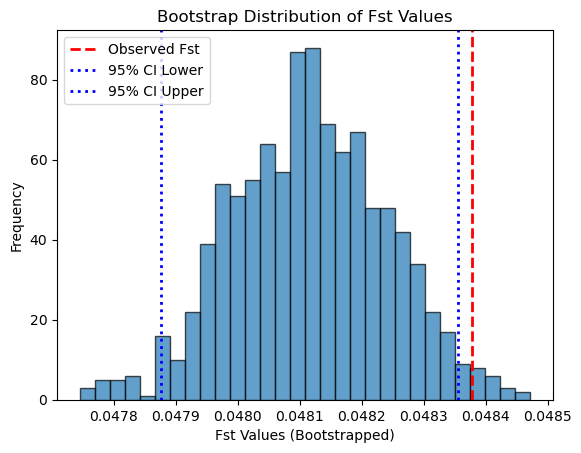

In [12]:
# Plot bootstrap Fst distribution
plt.hist(fst_bootstrapped, bins=30, edgecolor="black", alpha=0.7)
plt.axvline(boot_fst, color="red", linestyle="dashed", linewidth=2, label="Observed Fst")
plt.axvline(ci_lower, color="blue", linestyle="dotted", linewidth=2, label="95% CI Lower")
plt.axvline(ci_upper, color="blue", linestyle="dotted", linewidth=2, label="95% CI Upper")
plt.xlabel("Fst Values (Bootstrapped)")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of Fst Values")
plt.legend()
plt.show()